# Session 5: Generative Models

<p class="lead">
<a href="https://www.kadenze.com/courses/creative-applications-of-deep-learning-with-tensorflow/info">Creative Applications of Deep Learning with Google's Tensorflow</a><br />
<a href="http://pkmital.com">Parag K. Mital</a><br />
<a href="https://www.kadenze.com">Kadenze, Inc.</a>
</p>

<a name="learning-goals"></a>
## Learning Goals


<!-- MarkdownTOC autolink=true autoanchor=true bracket=round -->

- [Introduction](#introduction)
- [Generative Adversarial Networks](#generative-adversarial-networks)
    - [Input Pipelines](#input-pipelines)
    - [GAN/DCGAN](#gandcgan)
    - [Extensions](#extensions)
- [Recurrent Networks](#recurrent-networks)
    - [Basic RNN Cell](#basic-rnn-cell)
    - [LSTM RNN Cell](#lstm-rnn-cell)
    - [GRU RNN Cell](#gru-rnn-cell)
- [Character Langauge Model](#character-langauge-model)
    - [Setting up the Data](#setting-up-the-data)
    - [Creating the Model](#creating-the-model)
    - [Loss](#loss)
    - [Clipping the Gradient](#clipping-the-gradient)
    - [Training](#training)
    - [Extensions](#extensions-1)
- [DRAW Network](#draw-network)
- [Future](#future)
- [Homework](#homework)
- [Examples](#examples)
- [Reading](#reading)

<!-- /MarkdownTOC -->

In [1]:
# First check the Python version
import sys
if sys.version_info < (3,4):
    print('You are running an older version of Python!\n\n',
          'You should consider updating to Python 3.4.0 or',
          'higher as the libraries built for this course',
          'have only been tested in Python 3.4 and higher.\n')
    print('Try installing the Python 3.5 version of anaconda'
          'and then restart `jupyter notebook`:\n',
          'https://www.continuum.io/downloads\n\n')

# Now get necessary libraries
try:
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import data
    from scipy.misc import imresize
    from scipy.ndimage.filters import gaussian_filter
    import IPython.display as ipyd
    import tensorflow as tf
    from libs import utils, gif, datasets, dataset_utils, nb_utils
except ImportError as e:
    print("Make sure you have started notebook in the same directory",
          "as the provided zip file which includes the 'libs' folder",
          "and the file 'utils.py' inside of it.  You will NOT be able",
          "to complete this assignment unless you restart jupyter",
          "notebook inside the directory created by extracting",
          "the zip file or cloning the github repo.")
    print(e)

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Bit of formatting because I don't like the default inline code style:
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

<a name="introduction"></a>
# Introduction

So far we've seen the basics of neural networks, how they can be used for encoding large datasets, or for predicting labels.  We've also seen how to interrogate the deeper representations that networks learn in order to help with their objective, and how ampliyfing some of these objectives led to creating deep dream.  Finally, we saw how the representations in deep nets trained on object recognition are capable of representing both style and content, and how we could independently manipulate a new image to have the style of one image, and the content of another.

In this session we'll start to explore some more generative models.  We've already seen how an autoencoder is composed of both an encoder which takes an input and represents it into some hidden state vector.  From this hidden state vector, a decoder is capable of resynthsizing the original input, though with some loss.  So think back to the the decoders that we've already built.  It has an internal state, and from that state, it can express the entire distribution of the original data, that is, it can express any possible image that is has seen.

We call that a generative model as it is capable of generating the distribution of the data.  Contrast this to the latter half of Session 3 when we saw how ot label an image using supervised learning.  This model is really trying to discriminate the data distribution based on the extra labels that we have.  So this is another helpful distinction with machine learning algorithms, ones that are generative and others that are discriminative.

In this session, we'll explore more generative models, and states can be used to generate data in two other very powerful generative networks, one based on game theory called the generative adversarial network, and another capable of remembering and forgetting over time, allowing us to model dynamic content and sequences, called the recurrent neural network.

<a name="generative-adversarial-networks"></a>
# Generative Adversarial Networks

In session 3, we were briefly introduced to the Variational Autoencoder.  This network was very powerful because it encompasses a very strong idea.  And that idea is measuring distance not necessarily based on pixels, but in some "semantic space".  And I mentioned then that we'd see another type of network capable of generating even better images of CelebNet.

So this is where we're heading...

We're now going to see how to do that using what's called the generative adversarial network.

The generative adversarial network is actually two networks.  One called the generator, and another called the discriminator.  The basic idea is the generator is trying to create things which look like the training data.  So for images, more images that look like the training data.  The discriminator has to guess whether what its given is a real training example.  Or whether its the output of the generator.  By training one after another, you ensure neither are ever too strong, but both grow stronger together.  The discriminator is also learning a distance function!  This is pretty cool because we no longer need to measure pixel-based distance, but we learn the distance function entirely!

The Generative Adversarial Network, or GAN, for short, are in a way, very similar to the autoencoder we created in session 3.  Or at least the implementation of it is.  The discriminator is a lot like the encoder part of this network, except instead of going down to the 64 dimensions we used in our autoencoder, we'll reduce our input down to a single value, yes or no, 0 or 1, denoting yes its a true training example, or no, it's a generated one.

And the generator network is exactly like the decoder of the autoencoder.  Except, there is nothing feeding into this inner layer.  It is just on its own.  From whatever vector of hidden values it starts off with, it will generate a new example meant to look just like the training data.  One pitfall of this model is there is no explicit encoding of an input.  Meaning, you can't take an input and find what would possibly generate it.  However, there are recent extensions to this model which make it more like the autoencoder framework, allowing it to do this.

<a name="input-pipelines"></a>
## Input Pipelines

Before we get started, we're going to need to work with a very large image dataset, the CelebNet dataset.  In session 1, we loaded this dataset but only grabbed the first 1000 images.  That's because loading all 200 thousand images would take up a lot of memory which we'd rather not have to do.  And in Session 3 we were introduced again to the CelebNet and Sita Sings the Blues which required us to load a lot of images.  I glossed over the details of the input pipeline then so we could focus on learning the basics of neural networks.  But I think now we're ready to see how to handle some larger datasets.

Tensorflow provides operations for takinga list of files, using that list to load the data pointed to it, decoding that file's data as an image, and creating shuffled minibatches.  All of this is put into a queue and managed by queuerunners and coordinators.

As you may have already seen in the Variational Autoencoder's code, I've provided a simple interface for creating such an input pipeline using image files which will also apply cropping and reshaping of images in the pipeline so you don't have to deal with any of it.  Let's see how we can use it to load the CelebNet dataset.


Let's first get the list of all the CelebNet files:

In [3]:
import tensorflow as tf
from libs.datasets import CELEB
files = CELEB()

It does not look like you have downloaded the entire Celeb Dataset.
Try downloading the dataset from the "Aligned and Cropped" link located here (imgs/img_align_celeba.zip [1.34 GB]): http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html


And then create our input pipeline to create shuffled minibatches and crop the images to a standard shape.  This will require us to specify the list of files, how large each minibatch is, how many epochs we want to run for, and how we want the images to be cropped.

In [4]:
from libs.dataset_utils import create_input_pipeline
batch_size = 100
n_epochs = 10
input_shape = [218, 178, 3]
crop_shape = [64, 64, 3]
crop_factor = 0.8
batch = create_input_pipeline(
    files=files,
    batch_size=batch_size,
    n_epochs=n_epochs,
    crop_shape=crop_shape,
    crop_factor=crop_factor,
    shape=input_shape)

Then when we are ready to use the batch generator, we'll need to create a `Coordinator` and specify this to tensorflow using the `start_queue_runners` method in order to provide the data:

In [5]:
sess = tf.Session()
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

We can grab our data using our `batch` generator like so:

(100, 64, 64, 3)
float32 float32


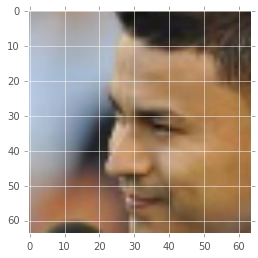

In [6]:
batch_xs = sess.run(batch)
# We get batch_size at a time, so 100
print(batch_xs.shape)
# The datatype is float32 since what is what we use in the tensorflow graph
# And the max value still has the original image range from 0-255
print(batch_xs.dtype, np.max(batch_xs.dtype))
# So to plot it, we'll need to divide by 255.
plt.imshow(batch_xs[0] / 255.0)

Let's see how to make use of this while we train a generative adversarial network!

<a name="gandcgan"></a>
## GAN/DCGAN

Inside the libs directory, you'll find `gan.py` which shows how to create a generative adversarial network with or without convolution, and how to train it using the CelebNet dataset.  Let's step through the code and then I'll show you what it's capable of doing.

-- Code demonstration not transcribed. -- 

<a name="extensions"></a>
## Extensions

So it turns out there are a ton of very fun and interesting extensions when you have a model in this space.  It turns out that you can perform addition in the latent space.  I'll just show you Alec Radford's code base on github to show you what that looks like.

<a name="recurrent-networks"></a>
# Recurrent Networks

Up until now, all of the networks that we've learned and worked with really have no sense of time.  They are static.  They cannot remember sequences, nor can they understand order outside of the spatial dimensions we offer it.  Imagine for instance that we wanted a network capable of reading.  As input, it is given one letter at a time.  So let's say it were given the letters 'n', 'e', 't', 'w', 'o', 'r', and we wanted it to learn to output 'k'.   It would need to be able to reason about inputs it received before the last one it received, the letters before 'r'.  But it's not just letters.

Consider the way we look at the world.  We don't simply download a high resolution image of the world in front of us.  We move our eyes.  Each fixation takes in new information and each of these together in sequence help us perceive and act.  That again is a sequential process.

Recurrent neural networks let us reason about information over multiple timesteps.  They are able to encode what it has seen in the past as if it has a memory of its own.  It does this by basically creating one HUGE network that expands over time.  It can reason about the current timestep by conditioning on what it has already seen.  By giving it many sequences as batches, it can learn a distribution over sequences which can model the current timestep given the previous timesteps.  But in order for this to be practical, we specify at each timestep, or each time it views an input, that the weights in each new timestep cannot change.  We also include a new matrix, `H`, which reasons about the past timestep, connecting each new timestep.  For this reason, we can just think of recurrent networks as ones with loops in it.

Other than that, they are exactly like every other network we've come across!  They will have an input and an output.  They'll need a loss or an objective function to optimize which will relate what we want the network to output for some given set of inputs.  And they'll be trained with gradient descent and backprop.

<a name="basic-rnn-cell"></a>
## Basic RNN Cell

The basic recurrent cell can be used in tensorflow as `tf.nn.rnn_cell.BasicRNNCell`.  Though for most complex sequences, especially longer sequences, this is almost never a good idea.  That is because the basic RNN cell does not do very well as time goes on.  To understand why this is, we'll have to learn a bit more about how backprop works.  When we perform backrprop, we're multiplying gradients from the output back to the input.  As the network gets deeper, there are more multiplications along the way from the output to the input.

Same for recurrent networks.  Remember, their just like a normal feedforward network with each new timestep creating a new layer.  So if we're creating an infinitely deep network, what will happen to all our multiplications?  Well if the derivatives are all greater than 1, then they will very quickly grow to infinity.  And if they are less than 1, then they will very quickly grow to 0. That makes them very difficult to train in practice.  The problem is known in the literature as the exploding or vanishing gradient problem.  Luckily, we don't have to figure out how to solve it, because some very clever people have already come up with a solution, in 1997!, yea, what were you doing in 1997.  Probably not coming up with they called the long-short-term-memory, or LSTM.

<a name="lstm-rnn-cell"></a>
## LSTM RNN Cell

The mechanics of this are unforunately far beyond the scope of this course, but put simply, it uses a combinations of gating cells to control its contents and by having gates, it is able to block the flow of the gradient, avoiding too many multiplications during backprop.  For more details, I highly recommend reading: https://colah.github.io/posts/2015-08-Understanding-LSTMs/.

In tensorflow, we can make use of this cell using `tf.nn.rnn_cell.LSTMCell`.

<a name="gru-rnn-cell"></a>
## GRU RNN Cell

One last cell type is worth mentioning, the gated recurrent unit, or GRU.  Again, beyond the scope of this class.  Just think of it as a simplifed version of the LSTM with 2 gates instead of 4, though that is not an accurate description.  In Tensorflow we can use this with `tf.nn.rnn_cell.GRUCell`.

<a name="character-langauge-model"></a>
# Character Langauge Model

We'll now try a fun application of recurrent networks where we try to model a corpus of text, one character at a time.  The basic idea is to take one character at a time and try to predict the next character in sequence.  Given enough sequences, the model is capable of generating entirely new sequences all on its own.

<a name="setting-up-the-data"></a>
## Setting up the Data

For data, we're going to start with text.  You can basically take any text file that is sufficiently long, as we'll need a lot of it, and try to use this.  This website seems like an interesting place to begin: http://textfiles.com/directory.html and project guttenberg https://www.gutenberg.org/browse/scores/top.  http://prize.hutter1.net/ also has a 50k euro reward for compressing wikipedia.  Let's try w/ Alice's Adventures in Wonderland by Lewis Carroll:

In [7]:
%pylab
import tensorflow as tf
from six.moves import urllib
#f, _ = urllib.request.urlretrieve('https://www.gutenberg.org/cache/epub/11/pg11.txt', 'alice.txt')
f = '/home/yosaikan/development/kadenze/CADL-master/session-5/wiki_ar.txt'
with open(f, 'r') as fp:
    txt = fp.read()

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


/home/yosaikan/.local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['resize']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


And let's find out what's inside this text file by creating a set of all possible characters.

In [8]:
vocab = list(set(txt))
len(txt), len(vocab)

(1065889, 47)

Great so we now have about 164 thousand characters and 85 unique characters in our vocabulary which we can use to help us train a model of language.  Rather than use the characters, we'll convert each character to a unique integer.  We'll later see that when we work with words, we can achieve a similar goal using a very popular model called word2vec: https://www.tensorflow.org/versions/r0.9/tutorials/word2vec/index.html

We'll first create a look up table which will map a character to an integer:

In [9]:
encoder = dict(zip(vocab, range(len(vocab))))
decoder = dict(zip(range(len(vocab)), vocab))

<a name="creating-the-model"></a>
## Creating the Model

For our model, we'll need to define a few parameters.

In [10]:
# Number of sequences in a mini batch
batch_size = 100

# Number of characters in a sequence
sequence_length = 100

# Number of cells in our LSTM layer
n_cells = 256

# Number of LSTM layers
n_layers = 2

# Total number of characters in the one-hot encoding
n_chars = len(vocab)

Now create the input and output to the network.  Rather than having `batch size` x `number of features`; or `batch size` x `height` x `width` x `channels`; we're going to have `batch size` x `sequence length`.

In [11]:
X = tf.placeholder(tf.int32, [None, sequence_length], name='X')

# We'll have a placeholder for our true outputs
Y = tf.placeholder(tf.int32, [None, sequence_length], name='Y')

Now remember with MNIST that we used a one-hot vector representation of our numbers.  We could transform our input data into such a representation.  But instead, we'll use `tf.nn.embedding_lookup` so that we don't need to compute the encoded vector.  Let's see how this works:

In [12]:
# we first create a variable to take us from our one-hot representation to our LSTM cells
embedding = tf.get_variable("embedding", [n_chars, n_cells])

# And then use tensorflow's embedding lookup to look up the ids in X
Xs = tf.nn.embedding_lookup(embedding, X)

# The resulting lookups are concatenated into a dense tensor
print(Xs.get_shape().as_list())

[None, 100, 256]


To create a recurrent network, we're going to need to slice our sequences into individual inputs.  That will give us timestep lists which are each `batch_size` x `input_size`.  Each character will then be connected to a recurrent layer composed of `n_cells` LSTM units.

In [13]:
# Let's create a name scope for the operations to clean things up in our graph
with tf.name_scope('reslice'):
    Xs = [tf.squeeze(seq, [1])
          for seq in tf.split(1, sequence_length, Xs)]

Now we'll create our recurrent layer composed of LSTM cells.

In [14]:
cells = tf.nn.rnn_cell.BasicLSTMCell(num_units=n_cells, state_is_tuple=True)

We'll initialize our LSTMs using the convenience method provided by tensorflow.  We could explicitly define the batch size here or use the `tf.shape` method to compute it based on whatever `X` is, letting us feed in different sizes into the graph.

In [15]:
initial_state = cells.zero_state(tf.shape(X)[0], tf.float32)

Great now we have a layer of recurrent cells and a way to initialize them.  If we wanted to make this a multi-layer recurrent network, we could use the `MultiRNNCell` like so:

In [16]:
if n_layers > 1:
    cells = tf.nn.rnn_cell.MultiRNNCell(
        [cells] * n_layers, state_is_tuple=True)
    initial_state = cells.zero_state(tf.shape(X)[0], tf.float32)

In either case, the cells are composed of their outputs as modulated by the LSTM's output gate, and whatever is currently stored in its memory contents.  Now let's connect our input to it.

In [17]:
# this will return us a list of outputs of every element in our sequence.
# Each output is `batch_size` x `n_cells` of output.
# It will also return the state as a tuple of the n_cells's memory and
# their output to connect to the time we use the recurrent layer.
outputs, state = tf.nn.rnn(cells, Xs, initial_state=initial_state)

# We'll now stack all our outputs for every cell
outputs_flat = tf.reshape(tf.concat(1, outputs), [-1, n_cells])

For our output, we'll simply try to predict the very next timestep.  So if our input sequence was "networ", our output sequence should be: "etwork".  This will give us the same batch size coming out, and the same number of elements as our input sequence.

In [18]:
with tf.variable_scope('prediction'):
    W = tf.get_variable(
        "W",
        shape=[n_cells, n_chars],
        initializer=tf.random_normal_initializer(stddev=0.1))
    b = tf.get_variable(
        "b",
        shape=[n_chars],
        initializer=tf.random_normal_initializer(stddev=0.1))

    # Find the output prediction of every single character in our minibatch
    # we denote the pre-activation prediction, logits.
    logits = tf.matmul(outputs_flat, W) + b

    # We get the probabilistic version by calculating the softmax of this
    probs = tf.nn.softmax(logits)

    # And then we can find the index of maximum probability
    Y_pred = tf.argmax(probs, 1)

<a name="loss"></a>
## Loss

Our loss function will take the reshaped predictions and targets, and compute the softmax cross entropy.

In [19]:
with tf.variable_scope('loss'):
    # Compute mean cross entropy loss for each output.
    Y_true_flat = tf.reshape(tf.concat(1, Y), [-1])
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, Y_true_flat)
    mean_loss = tf.reduce_mean(loss)

<a name="clipping-the-gradient"></a>
## Clipping the Gradient

Normally, we would just create an optimizer, give it a learning rate, and tell it to minize our loss.  But with recurrent networks, we can help out a bit by telling it to clip gradients.  That helps with the exploding gradient problem, ensureing they can't get any bigger than the value we tell it.  We can do that in tensorflow by iterating over every gradient and variable, and changing their value before we apply their update to every trainable variable.

In [ ]:
with tf.name_scope('optimizer'):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    gradients = []
    clip = tf.constant(5.0, name="clip")
    for grad, var in optimizer.compute_gradients(mean_loss):
        gradients.append((tf.clip_by_value(grad, -clip, clip), var))
    updates = optimizer.apply_gradients(gradients)

We could also explore other methods of clipping the gradient based on a percentile of the norm of activations or other similar methods, like when we explored deep dream regularization.  But the LSTM has been built to help regularize the network through its own gating mechanisms, so this may not be the best idea for your problem.  Really, the only way to know is to try different approaches and see how it effects the output on your problem.

<a name="training"></a>
## Training

In [ ]:
sess = tf.Session()
init = tf.initialize_all_variables()
sess.run(init)

cursor = 0
it_i = 0
while True:
    Xs, Ys = [], []
    for batch_i in range(batch_size):
        if (cursor + sequence_length) >= len(txt) - sequence_length - 1:
            cursor = 0
        Xs.append([encoder[ch]
                   for ch in txt[cursor:cursor + sequence_length]])
        Ys.append([encoder[ch]
                   for ch in txt[cursor + 1: cursor + sequence_length + 1]])

        cursor = (cursor + sequence_length)
    Xs = np.array(Xs).astype(np.int32)
    Ys = np.array(Ys).astype(np.int32)

    loss_val, _ = sess.run([mean_loss, updates],
                           feed_dict={X: Xs, Y: Ys})
    print(it_i, loss_val)

    if it_i % 50 == 0:
        p = sess.run([Y_pred], feed_dict={X: Xs})[0]
        preds = [decoder[p_i] for p_i in p]
        print("".join(preds).split('\n'))

    it_i += 1

0 3.76816
[' ةةم                                                                                           ل                                                                                                                                                                                                                  يي                                                                                                                         اا            للل                                                          ل  ا                                                                                                                                                                                     لللل                                                                                                                                                                                                 لللل         ا                                                                   للل                  

<a name="extensions-1"></a>
## Extensions

There are also certainly a lot of additions we can add to speed up or help with training including adding dropout or using batch normalization that I haven't gone into here.  Also when dealing with variable length sequences, you may want to consider using a special token to denote the last character or element in your sequence.

As for applications, *completley endless*.  And I think that is really what makes this field so exciting right now.  There doesn't seem to be any limit to what is possible right now.  You are not just limited to text first of all.  You may want to feed in MIDI data to create a piece of algorithmic music.  I've tried it with raw sound data and this even works, but it requires a lot of memory and at least 30k iterations to run before it sounds like anything.  Or perhaps you might try some other unexpected text based information, such as encodings of image data like JPEG in base64.  Or other compressed data formats.  Or perhaps you are more adventurous and want to try using what you've learned here with the previous sessions to add recurrent layers to a traditional convolutional model.

<a name="future"></a>
# Future

If you're still here, then I'm really excited for you and to see what you'll create.  By now, you've seen most of the major building blocks with neural networks.  From here, you are only limited by the time it takes to train all of the interesting ideas you'll have.  But there is still so much more to discover, and it's very likely that this entire course is already out of date, because this field just moves incredibly fast.  In any case, the applications of these techniques are still fairly stagnant, so if you're here to see how your creative practice could grow with these techniques, then you should already have plenty to discover.

I'm very excited about how the field is moving.  Often, it is very hard to find labels for a lot of data in a meaningful and consistent way.  But there is a lot of interesting stuff starting to emerge in the unsupervised models.  Those are the models that just take data in, and the computer reasons about it.  And even more interesting is the combination of general purpose learning algorithms.  That's really where reinforcement learning is starting to shine.  But that's for another course, perhaps.

<a name="reading"></a>
# Reading

Ian J. Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, Yoshua Bengio. Generative Adversarial Networks. 2014.
https://arxiv.org/abs/1406.2661

Ian J. Goodfellow, Jonathon Shlens, Christian Szegedy.  Explaining and Harnessing Adversarial Examples.  2014.

Alec Radford, Luke Metz, Soumith Chintala. Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks. 2015.
https://arxiv.org/abs/1511.06434

Emily Denton, Soumith Chintala, Arthur Szlam, Rob Fergus. 
Deep Generative Image Models using a Laplacian Pyramid of Adversarial Networks. 2015.
arxiv.org/abs/1506.05751

Anders Boesen Lindbo Larsen, Søren Kaae Sønderby, Hugo Larochelle, Ole Winther. Autoencoding beyond pixels using a learned similarity metric. 2015.
https://arxiv.org/abs/1512.09300

Vincent Dumoulin, Ishmael Belghazi, Ben Poole, Alex Lamb, Martin Arjovsky, Olivier Mastropietro, Aaron Courville.  Adversarially Learned Inference.  2016.
https://arxiv.org/abs/1606.00704

Ilya Sutskever, James Martens, and Geoffrey Hinton. Generating Text with Recurrent Neural Networks, ICML 2011. 

A. Graves. Generating sequences with recurrent neural networks. In Arxiv preprint, arXiv:1308.0850, 2013.

T. Mikolov, I. Sutskever, K. Chen, G. S. Corrado, and J. Dean. Distributed representations of words and phrases and their compositionality. In Advances in
Neural Information Processing Systems, pages 3111–3119, 2013.

J. Pennington, R. Socher, and C. D. Manning. Glove: Global vectors for word representation. Proceedings of the Empiricial Methods in Natural Language Processing (EMNLP 2014), 12, 2014.

Yoon Kim, Yacine Jernite, David Sontag, Alexander M. Rush. Character-Aware Neural Language Models. 2015.
https://arxiv.org/abs/1508.06615

I. Sutskever, J. Martens, and G. Hinton. Generating text with recurrent neural networks. In L. Getoor and T. Scheffer, editors, Proceedings of the 28th International Conference on Machine Learning (ICML-11), ICML ’11, pages 1017–1024, New York, NY, USA, June 2011. ACM.